In [1]:
import sys
print(sys.executable)
print(sys.version)

/u/60/pereire1/unix/miniconda3/envs/noqula/bin/python
3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]


In [2]:
import tensorflow as tf
print(tf.__version__)


2025-12-01 16:27:39.369086: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 16:27:39.467353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764599259.499889  757295 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764599259.504686  757295 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764599259.520064  757295 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

2.19.0


In [3]:
import numpy as np
import math as m
import scipy
from scipy import linalg
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow import keras

In [4]:
# Generate input data


# Fidelity calculation functions

def fidelity_imag(y_pred1, y_true1):
    y_pred_imag = y_pred1
    y_true_imag = y_true1
    ai = y_pred_imag
    bi = y_true_imag
    ci = ai * bi
    F_imag = (np.mean(ci) - np.mean(ai) * np.mean(bi)) / (
        (np.mean(np.square(ai)) - np.square(np.mean(ai))) *
        (np.mean(np.square(bi)) - np.square(np.mean(bi))) 
        )** 0.5
    return F_imag

# Create neural network model
def create_model(input_shape):
    x_input = Input(shape=input_shape, name="x_input")
    x = Dense(40, activation="relu", kernel_initializer="glorot_uniform")(x_input)
    x = Dense(30, activation="relu", kernel_initializer="glorot_uniform")(x)
    x = Dense(20, activation="relu", kernel_initializer="glorot_uniform")(x)
    x = Dense(10, activation="relu", kernel_initializer="glorot_uniform")(x)
    x = Dense(5, activation="relu", kernel_initializer="glorot_uniform")(x)
    output = Dense(1)(x)
    model = Model(x_input, output)
    return model

def create_model_cgpt(input_shape):
    x_input = Input(shape=input_shape, name="x_input")
    
    x = Dense(128, activation="tanh", kernel_initializer="glorot_uniform")(x_input)
    x = BatchNormalization()(x)
    x = Dense(64, activation="tanh", kernel_initializer="glorot_uniform")(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation="tanh", kernel_initializer="glorot_uniform")(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation="tanh", kernel_initializer="glorot_uniform")(x)
    
    output = Dense(1)(x)
    model = Model(inputs=x_input, outputs=output)
    return model

def create_model1(input_shape): #model to prevent overfitting
    # Input layer
    x_input = Input(shape=input_shape, name="x_input")
    # First Dense layer with L2 regularization and Dropout
    x = Dense(40, activation="relu", kernel_initializer="glorot_uniform", 
              kernel_regularizer=l2(0.001))(x_input)
    x = Dropout(0.3)(x)  # Dropout with a rate of 0.3
    # Second Dense layer with L2 regularization and Dropout
    x = Dense(20, activation="relu", kernel_initializer="glorot_uniform", 
              kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)  # Dropout with a rate of 0.3
    # Third Dense layer with L2 regularization and Dropout
    x = Dense(10, activation="relu", kernel_initializer="glorot_uniform", 
              kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)  # Dropout with a rate of 0.3
    # Output layer
    output = Dense(1)(x)
    # Create and return the model
    model = Model(x_input, output)
    return model

def learning_rate_scheduler(epoch):
    initial_learning_rate = 0.001  # Initial learning rate
    if epoch <= 1:
        return initial_learning_rate
    else:
        decay = 0.975  # Learning rate decay factor
        lr = initial_learning_rate * (decay ** epoch)
        return lr

In [5]:
# Add noise to data
def adding_noise(p1, q1, noise_std):
    noise1 = np.random.normal(0, noise_std, size=p1.shape)
    noise2 = np.random.normal(0, noise_std, size=q1.shape)
    p2 = np.concatenate([p1, p1 + noise1], axis=0)
    q2 = np.concatenate([q1, q1 + noise2], axis=0)  
    indices = np.arange(len(p2))
    np.random.shuffle(indices)
    return p2[indices], q2[indices]



def adding_noise_log(p1, q1, noise_std):
    noise1 = np.random.lognormal(mean=0.0, sigma=noise_std, size=p1.shape)
    noise2 = np.random.lognormal(mean=0.0, sigma=noise_std, size=q1.shape)
    p2 = p1 * noise1  # Multiplicative noise keeps values non-negative
    q2 = q1 * noise2
    return p2, q2

In [6]:
import numpy as np

def select_individual_datay_matches(datay, X, ref_puc_phases, epsilon):
    """
    Select individual elements from datay that match the corresponding ref_puc_phases[j] ± epsilon[j].
    Then extract the corresponding rows from X and Y (each datay[i] maps to 8 rows in X/Y).

    Parameters:
        datay: (N, 8) array of data values
        X, Y: (N*8, 40) arrays of features/labels
        ref_puc_phases: (8,) array of reference values for each ring
        epsilon: (8,) array of tolerance values per ring

    Returns:
        chosendatay: (num_matches,) — selected scalar values
        chosenX: (num_matches, 40)
        chosenY: (num_matches, 40)
    """
    n_datapoints, n_rings = datay.shape
    assert X.shape[0] == n_datapoints * n_rings
    assert ref_puc_phases.shape[0] == epsilon.shape[0] == n_rings

    chosendatay = []
    chosenX = []
    chosenY = []

    for i in range(n_datapoints):
        for j in range(n_rings):
            val = datay[i, j]
            if abs(val - ref_puc_phases[j]) <= epsilon[j]:
                index = i * n_rings + j
                chosendatay.append(val)
                chosenX.append(X[index])

    return np.array(chosendatay).flatten(), np.array(chosenX)

def select_datay_ring_major_order(datay, X, ref_freqs, epsilon):
    datay = np.array(datay)
    ref_freqs = np.array(ref_freqs)
    epsilon = np.array(epsilon)
    
    n_datapoints, n_rings = datay.shape
    assert X.shape[0] == n_datapoints * n_rings
    assert ref_freqs.shape[0] == epsilon.shape[0] == n_rings

    chosendatay = []
    chosenX = []
    chosenY = []

    for i in range(n_datapoints):          # loop over each row
        for j in range(n_rings):           # loop over each ring
            val = datay[i, j]
            if abs(val - ref_freqs[j]) <= epsilon[j]:
                idx = i * n_rings + j
                chosendatay.append(val)
                chosenX.append(X[idx])

    return np.array(chosendatay), np.array(chosenX)


In [7]:
import numpy as np
import os

# Define file path
#folder_name = "data with random puc phase for given onsite loss"
file_pathy = os.path.join("finalized_resonant_freqs_wrt_ref_phase_using_fsr_and_puc_phases.txt")


# Load the data (assuming space-separated values)
datay = np.loadtxt(file_pathy, delimiter=" ")
print("datay shape:", datay.shape)

file_pathx = os.path.join("full.txt") #without including the compensation of intrinsic losses
#file_pathx = os.path.join("compensated_spectral_data.txt") #after including the compensation of intrinsic losses

# Load the data as a 2D NumPy array
dataX = np.loadtxt(file_pathx, delimiter=" ")
Xp = 10.**(dataX/10.)
# Print shape to verify
print("Xp shape:", Xp.shape)


datay shape: (300, 8)
Xp shape: (2400, 40)


In [8]:
import numpy as np
FSRs_ang = np.array([81.06753754801633, 83.41732126685432, 83.41764401355516, 82.24227030736816, 
                 82.24290670919115, 82.24258850750248, 82.24258850750248, 83.41764401355516])
FSRs_scaling = FSRs_ang/(2.*np.pi)/4.
l = [0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15]
Losses = l * FSRs_scaling
print(Losses)
Losses = np.array(Losses)  # example losses

# Repeat Losses to match number of rows in Xp
scaling = np.tile(Losses, Xp.shape[0] // Losses.shape[0])  # shape (2400,)

# Reshape to (2400, 1) to broadcast across columns
Xp_scaled = Xp / (4.*np.pi*scaling[:, np.newaxis])  # final shape (2400, 40)

[0.48383622 0.49786046 0.49786239 0.49084739 0.49085119 0.49084929
 0.49084929 0.49786239]


In [9]:
epsilon = np.array([5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5])/1.
#epsilon = np.array([6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0])/1.

In [10]:
chosendatay, chosenX = select_datay_ring_major_order(datay, Xp_scaled,np.zeros_like(epsilon), epsilon)

print("shape of chosendatay : ",chosendatay.shape)
print("shape of chosenX : ",chosenX.shape)

shape of chosendatay :  (1533,)
shape of chosenX :  (1533, 40)


In [11]:
#X_train, X_test, y_train, y_test = train_test_split(Xp_scaled, datay.flatten(), test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(chosenX, chosendatay, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(1226, 40)
(307, 40)


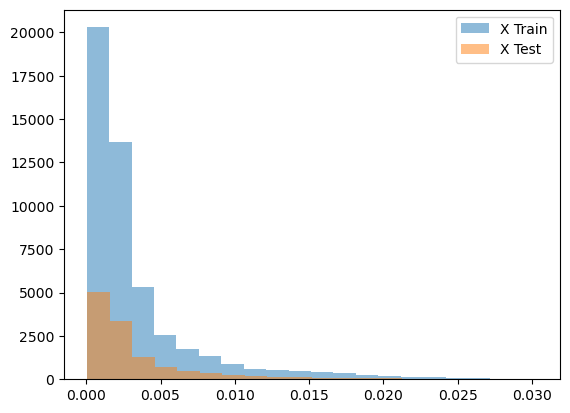

In [12]:
import matplotlib.pyplot as plt
plt.hist(X_train.flatten(), bins=20, alpha=0.5, label="X Train")
plt.hist(X_test.flatten(), bins=20, alpha=0.5, label="X Test")
plt.legend()
plt.show()

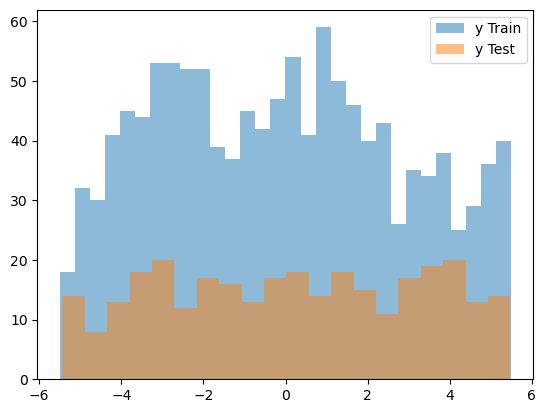

In [13]:
import matplotlib.pyplot as plt
plt.hist(y_train.flatten(), bins=30, alpha=0.5, label="y Train")
plt.hist(y_test.flatten(), bins=20, alpha=0.5, label="y Test")
plt.legend()
plt.show()

In [14]:
scalerx = StandardScaler()
X_train_scaled = scalerx.fit_transform(X_train)
X_test_scaled = scalerx.transform(X_test)
#X_train_scaled = X_train
#X_test_scaled = X_test

from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.pipeline import make_pipeline

target_scaler = make_pipeline(PowerTransformer(method='yeo-johnson', standardize=True), MinMaxScaler())
y_train0=y_train.reshape(-1,1)
target_scaler.fit(y_train0)
y_train_scaled=target_scaler.transform(y_train.reshape(-1,1))
y_test_scaled=target_scaler.transform(y_test.reshape(-1,1))


#scalery = StandardScaler()
#y_train_scaled = scalery.fit_transform(y_train.reshape(-1, 1))
#y_test_scaled = scalery.transform(y_test.reshape(-1, 1))

#y_train_scaled = y_train
#y_test_scaled = y_test

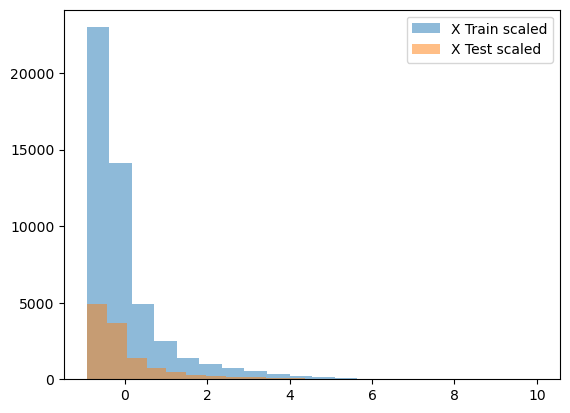

In [15]:
import matplotlib.pyplot as plt
plt.hist(X_train_scaled.flatten(), bins=20, alpha=0.5, label="X Train scaled")
plt.hist(X_test_scaled.flatten(), bins=20, alpha=0.5, label="X Test scaled")
plt.legend()
plt.show()

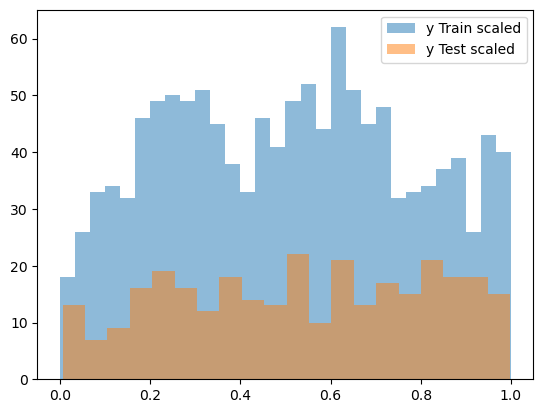

In [16]:
import matplotlib.pyplot as plt
plt.hist(y_train_scaled.flatten(), bins=30, alpha=0.5, label="y Train scaled")
plt.hist(y_test_scaled.flatten(), bins=20, alpha=0.5, label="y Test scaled")
plt.legend()
plt.show()

In [17]:
model = create_model(input_shape=X_train_scaled.shape[1:])
#model = create_model_cgpt(input_shape=X_train_scaled.shape[1:])
#model = create_model1(input_shape=X_train_scaled.shape[1:])

#model = create_model(input_shape=X_train_pca.shape[1:])

model.compile(optimizer="adam", loss="mse")
lr_scheduler_callback = keras.callbacks.LearningRateScheduler(learning_rate_scheduler)
#history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=16, validation_split=0.2)
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=16, validation_split=0.2,callbacks=[lr_scheduler_callback])

#history = model.fit(X_train_pca, y_train_scaled, epochs=100, batch_size=16, validation_split=0.2)

loss = model.evaluate(X_test_scaled, y_test_scaled)
#loss = model.evaluate(X_test_pca, y_test_scaled)
print(f"Test Loss :", loss)

# Predictions
y_pred_test = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)

#y_pred_test = model.predict(X_test_pca)
#y_pred_train = model.predict(X_train_pca)

print(y_pred_train.shape)
print(y_train.shape)
print(y_pred_test.shape)
print(y_test.shape)

Epoch 1/100


2025-12-01 16:27:46.249269: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2628 - val_loss: 0.0241 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0187 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0087 - val_loss: 0.0086 - learning_rate: 9.5062e-04
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0053 - val_loss: 0.0073 - learning_rate: 9.2686e-04
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_loss: 0.0069 - learning_rate: 9.0369e-04
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0038 - val_loss: 0.0061 - learning_rate: 8.8110e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036 - val_loss: 0.0059 - learning_rate: 8.5907e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031 - val_loss: 0.0055 - learning_rate: 8.3759e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029 - val_loss: 0.0056 - learning_rate: 8.1665e-04
Epo

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010 - val_loss: 0.0034 - learning_rate: 2.4846e-04
Epoch 57/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.3108e-04 - val_loss: 0.0035 - learning_rate: 2.4225e-04
Epoch 58/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.4842e-04 - val_loss: 0.0034 - learning_rate: 2.3619e-04
Epoch 59/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7355e-04 - val_loss: 0.0035 - learning_rate: 2.3029e-04
Epoch 60/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.1068e-04 - val_loss: 0.0034 - learning_rate: 2.2453e-04
Epoch 61/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5068e-04 - val_loss: 0.0035 - learning_rate: 2.1892e-04
Epoch 62/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8258e-04 - val_loss: 0.0034 - learning_rate: 2.1344e-04
Epoch 63/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.9577e-04 - val_loss: 0.0034 - learning_rate: 2.0811e-04
Epoch 64/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7499e-04 - 

In [18]:
print(X_test_scaled.shape)
print(y_test_scaled.shape)
print(type(X_test_scaled), type(y_test_scaled))
print(hasattr(X_test_scaled, 'shape'), hasattr(y_test_scaled, 'shape'))


(307, 40)
(307, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
True True


In [19]:
y_preds_test = []
y_preds_train = []
n_runs = 50

for n1 in range(n_runs):
    preds_test = model.predict(X_test_scaled)
    #preds_test = model.predict(X_test_pca)
    y_preds_test.append(preds_test)
    
    preds_train = model.predict(X_train_scaled)
    #preds_train = model.predict(X_train_pca)
    y_preds_train.append(preds_train)
    print(n1)

# Stack and average the predictions
#y_preds_test = np.stack(y_pred_test, axis=0)  # shape: (n_runs, num_samples, output_dim)
y_pred_mean_test = np.mean(y_preds_test, axis=0)  # shape: (num_samples, output_dim)

#y_preds_train = np.stack(y_pred_train, axis=0)  # shape: (n_runs, num_samples, output_dim)
y_pred_mean_train = np.mean(y_preds_train, axis=0)  # shape: (num_samples, output_dim)

print("Test : Average predicted values shape:", y_pred_mean_test.shape)
print("Train : Average predicted values shape:", y_pred_mean_train.shape)



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step
0
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
1
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
3
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
4
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
6
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
7
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
9
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
11
10

In [20]:
print("Test : Average predicted values shape:", len(y_preds_test))
print("Train : Average predicted values shape:", len(y_preds_train))
y_pred_test = y_pred_mean_test
y_pred_train = y_pred_mean_train


Test : Average predicted values shape: 50
Train : Average predicted values shape: 50


In [21]:
#y_pred_train = np.squeeze(scalery.inverse_transform(y_pred_train.reshape(-1, 1)))  # Flattening to shape (40000,)
#y_train1 = np.squeeze(scalery.inverse_transform(y_train_scaled.reshape(-1, 1)))
#y_pred_test = np.squeeze(scalery.inverse_transform(y_pred_test.reshape(-1, 1)))  # Flattening to shape (40000,)
#y_test1 = np.squeeze(scalery.inverse_transform(y_test_scaled.reshape(-1, 1)))

#y_pred_train = np.squeeze(y_pred_train.reshape(-1, 1))  # Flattening to shape (40000,)
#y_train1 = np.squeeze(y_train_scaled.reshape(-1, 1))
#y_pred_test = np.squeeze(y_pred_test.reshape(-1, 1))  # Flattening to shape (40000,)
#y_test1 = np.squeeze(y_test_scaled.reshape(-1, 1))

y_pred_train1 = np.squeeze(target_scaler.inverse_transform(y_pred_train.reshape(-1, 1)))  # Flattening to shape (40000,)
y_train1 = np.squeeze(target_scaler.inverse_transform(y_train_scaled.reshape(-1, 1)))
y_pred_test1 = np.squeeze(target_scaler.inverse_transform(y_pred_test.reshape(-1, 1)))  # Flattening to shape (40000,)
y_test1 = np.squeeze(target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)))
print(np.max(y_pred_test))
# Fidelity
F_imag_train = fidelity_imag(y_pred_train1, y_train1)
F_imag = fidelity_imag(y_pred_test1, y_test1)
    
print(f"Fidelity (Imag): Train ( {F_imag_train:.4f}), Test ({F_imag:.4f})")

# Diagnostics: Check for constant outputs
print(f"Variance of Predictions (Train): {np.var(y_pred_train, axis=0)}")
print(f"Variance of Predictions (Test): {np.var(y_pred_test, axis=0)}")

# Save results
#with open("mllresults6.dat", "a") as file21:
#    file21.write(f"{noise_std} {F_real_train:.4f} {F_imag_train:.4f} {F_real:.4f} {F_imag:.4f}\n")

1.0832072
Fidelity (Imag): Train ( 0.9916), Test (0.9814)
Variance of Predictions (Train): [0.07105148]
Variance of Predictions (Test): [0.07624803]


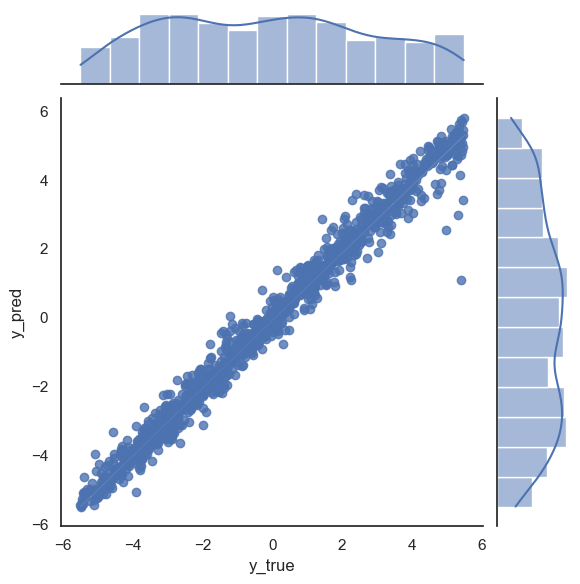

In [22]:
import pandas as pd
import seaborn as sns
y_true =y_train1.flatten() #y_train_scaled.flatten()
y_pred = y_pred_train1.flatten()

#Convert validation predictions to pandas dataframe
df_pred_train = pd.DataFrame({'y_true':y_true, 'y_pred': y_pred})

# Create scatter plot with histograms for visualizing the density
sns.set(style="white", color_codes=True)
g = sns.jointplot(x='y_true', y='y_pred', data=df_pred_train, kind="reg")

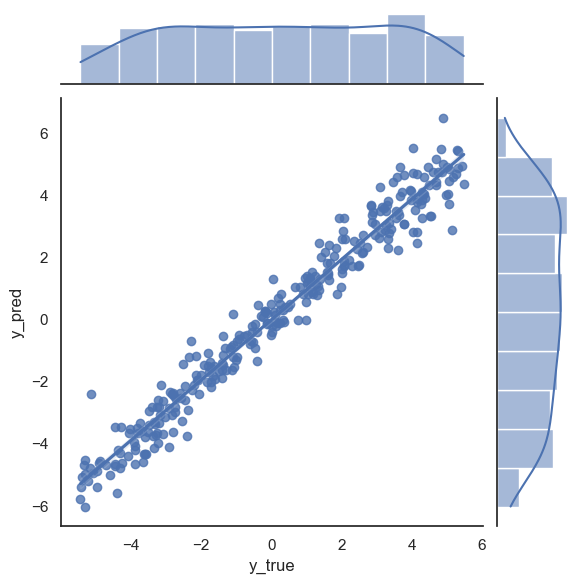

In [23]:
import pandas as pd
import seaborn as sns
y_truet = y_test1.flatten()   #y_test_scaled.flatten()
y_predt = y_pred_test1.flatten()

#Convert validation predictions to pandas dataframe
df_pred_test = pd.DataFrame({'y_true':y_truet, 'y_pred': y_predt})

# Create scatter plot with histograms for visualizing the density
sns.set(style="white", color_codes=True)
g = sns.jointplot(x='y_true', y='y_pred', data=df_pred_test, kind="reg")

In [24]:
def eigensys(v,vtilde):
    N = len(v)
    H1 = np.diag(v*1 -vtilde*(1j)) + 0.82*np.eye(N, k=1) + 0.82*np.eye(N, k=-1)
    return H1*2.*np.pi

def gpower(w11, vl, vp, freq1,gamma):
    pw = np.square(np.abs((np.sum(np.conj(vl) * vp / (freq1 - w11+ 1j * gamma), axis=1))))
   # pw = np.abs((np.sum(np.conj(vl) * vp / (freq1 - w11 + 1j * 0.01), axis=1)))
    return pw #/np.pi

def gpower_edited(w11, vl, vp, angular_freq1,gamma):
    #pw = np.square(np.abs((np.sum(np.conj(vl) * vp / (freq1 - w11 + 1j * gamma), axis=1))))
    pw = np.square(np.abs((np.sum(np.conj(vl) * vp / (angular_freq1 - w11+ 1j *gamma), axis=1))))
    return pw


def orthomatrix(vl21, vl22):
    M = np.conj(vl21.T) @ vl22
    return M

def newbiorth1(vl11, vl12,N1):
    M = orthomatrix(vl11, vl12)
    #print(M)
    p, l, u = linalg.lu(M)
    linv = linalg.inv(p @ l)
    uinv = linalg.inv(u)
    vlp1 = linv @ np.conj(np.transpose(vl11))
    vlp2 = vl12 @ uinv
    M1 = vlp1 @ vlp2
    is_biorthogonal = np.allclose(M1, np.eye(N1), atol=1e-10)
    #print(f"Biorthogonality check: {'Passed' if is_biorthogonal else 'Failed'}")
    #print(M1)
    return np.conj(np.transpose(vlp1)), vlp2

In [25]:
file_pathfrequencies = os.path.join("frequencies.txt")
frequencies = 2.*np.pi*np.loadtxt(file_pathfrequencies, delimiter=" ")

frequencies_num = list(enumerate(frequencies))
print("length of frequencies :", len(frequencies))

y_combined_true = np.concatenate([y_true, y_truet], axis=0)[:1528].reshape(-1, 8)
y_combined_pred = np.concatenate([y_pred, y_predt], axis=0)[:1528].reshape(-1, 8)
new_chosenX_combined = np.concatenate([X_train, X_test], axis=0)[:1528]

print("y_combined_true shape :", y_combined_true.shape)  
print("y_combined_pred shape :", y_combined_pred.shape)
print("new_chosenX_combined shape :", new_chosenX_combined.shape)

length of frequencies : 40
y_combined_true shape : (191, 8)
y_combined_pred shape : (191, 8)
new_chosenX_combined shape : (1528, 40)


In [26]:
FSRs_ang = np.array([81.06753754801633, 83.41732126685432, 83.41764401355516, 82.24227030736816, 
                 82.24290670919115, 82.24258850750248, 82.24258850750248, 83.41764401355516])
FSRs_scaling = FSRs_ang/(2.*np.pi)/4.
l = [0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15]
Losses = l * FSRs_scaling
print(Losses)

X_true = np.zeros((y_combined_true.shape[0] *y_combined_true.shape[1] , len(frequencies)), dtype=np.float64)
X_predicted = np.zeros((y_combined_pred.shape[0] *y_combined_pred.shape[1] , len(frequencies)), dtype=np.float64)

for i1 in range(y_combined_true.shape[0]):
    Ham_true = eigensys(y_combined_true[i1,:],Losses)
    w_true, vl1_true, vl2_true = linalg.eig(Ham_true, left=True, right=True)
    vlp1_true, vlp2_true = newbiorth1(vl1_true, vl2_true,y_combined_true.shape[1])
    
    Ham_predicted = eigensys(y_combined_pred[i1,:],Losses)
    w_predicted, vl1_predicted, vl2_predicted = linalg.eig(Ham_predicted, left=True, right=True)
    vlp1_predicted, vlp2_predicted = newbiorth1(vl1_predicted, vl2_predicted,y_combined_pred.shape[1])
    
    for i2, freq in frequencies_num:
        X_true[i1 * y_combined_true.shape[1]: (i1 + 1) * y_combined_true.shape[1], i2] = gpower_edited(w_true, vlp1_true, vlp2_true, freq,gamma=0.5)   
        X_predicted[i1 * y_combined_pred.shape[1]: (i1 + 1) * y_combined_pred.shape[1], i2] = gpower_edited(w_predicted, vlp1_predicted, vlp2_predicted, freq,gamma=0.5)     
print("X_true shape :", X_true.shape)  
print("X_predicted shape :", X_predicted.shape) 

[0.48383622 0.49786046 0.49786239 0.49084739 0.49085119 0.49084929
 0.49084929 0.49786239]
X_true shape : (1528, 40)
X_predicted shape : (1528, 40)


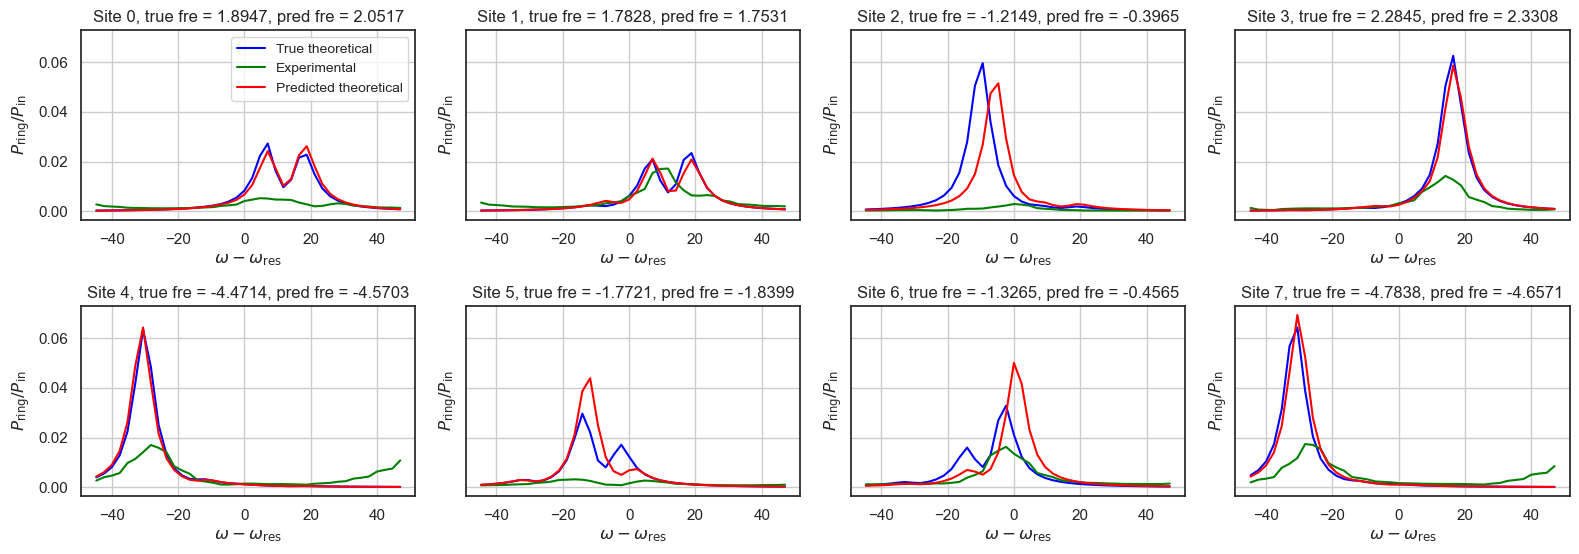

In [27]:
import numpy as np
import matplotlib.pyplot as plt

plotx = frequencies


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True, sharey=True)
#fig.suptitle("Experimental vs Theoretical Spectra", fontsize=16)

k = 7 #0 to 39
for i in range(8):
    ax = axes[i // 4, i % 4]  # Row-major order: 2 rows, 4 columns

    ax.plot(frequencies, X_true[i+(8*k), :], label='True theoretical', color='blue')
    ax.plot(frequencies, new_chosenX_combined[i+(8*k), :], label='Experimental', color='green')
    #ax.plot(frequencies, non_comp_X[i+(8*k), :], label='Experimental (norm) (not compensated)', color='green')
    ax.plot(frequencies, X_predicted[i+(8*k), :], label='Predicted theoretical', color='red')

    #ax.set_title(f"Site {i}, sample {k+1}")
    ax.set_title(f"Site {i}, true fre = {y_combined_true[k,i]:.4f}, pred fre = {y_combined_pred[k,i]:.4f}")
    ax.set_xlabel(r"$\omega-\omega_{\mathrm{res}}$")
    ax.set_ylabel(r"$P_{\mathrm{ring}}/P_{\mathrm{in}}$")
    #ax.set_ylim(y_min, y_max)
    ax.grid(True)
    
    if i // 4 == 0:  # First row: force show x-tick labels
        ax.tick_params(labelbottom=True)

    if i == 0:
        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
#plt.savefig("spectra_sample_24.png", dpi=300, bbox_inches='tight')
plt.show()

In [28]:
# Create neural network model
from tensorflow.keras import layers, Model, Input

def create_model_for_sanity_check(input_shape):
    x_input = Input(shape=input_shape, name="x_input")
    x = Dense(64, activation="relu", kernel_initializer="glorot_uniform")(x_input)
    x = Dense(64, activation="relu", kernel_initializer="glorot_uniform")(x)
    x = Dense(40, activation="linear")(x)  # Output dimension is 40
    model = Model(inputs=x_input, outputs=x)
    return model

def create_model_for_sanity_check1(input_shape):
    x_input = Input(shape=input_shape, name="x_input")
    
    x = Dense(128, activation="relu", kernel_initializer="glorot_uniform", kernel_regularizer=l2(0.001))(x_input)
    x = Dropout(0.3)(x)
    
    x = Dense(64, activation="relu", kernel_initializer="glorot_uniform", kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    
    x = Dense(40, activation="linear")(x)  # Output dimension is 40 for regression
    
    model = Model(inputs=x_input, outputs=x)
    return model

def create_stage2_cnn(input_shape):
    x_input = Input(shape=input_shape, name="x_input")
    x = layers.Conv1D(64, 7, activation='relu', padding='same')(x_input)
    x = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(input_shape[0], activation='linear')(x)
    return Model(inputs=x_input, outputs=x)

from tensorflow.keras import layers, regularizers, Model, Input

def simple_spectrum_cnn(input_dim=40, l2=1e-4, p_drop=0.25, spatial_drop=0.15):
    # expects X shaped (None, input_dim, 1); y shaped (None, input_dim)
    x_in = Input(shape=(input_dim, 1), name="x_input")

    x = layers.Conv1D(32, 7, padding='same',
                      kernel_regularizer=regularizers.l2(l2))(x_in)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout1D(spatial_drop)(x)

    x = layers.Conv1D(48, 5, padding='same',
                      kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # light downsample without adding params
    x = layers.MaxPooling1D(pool_size=2)(x)

    # global pooling keeps params tiny and resists overfit
    x = layers.GlobalAveragePooling1D()(x)

    # tiny head
    x = layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(p_drop)(x)

    y_out = layers.Dense(input_dim, activation='linear', name="y_out")(x)
    return Model(inputs=x_in, outputs=y_out)


In [29]:
new_X = X_predicted
new_Y = new_chosenX_combined
print(new_X.shape,new_Y.shape)
new_X_train, new_X_test, new_y_train, new_y_test,y_comb_pred_train,y_comb_pred_test = train_test_split(new_X, new_Y,y_combined_pred.flatten(), test_size=0.2)
print(new_X_train.shape)
print(new_X_test.shape)
print(y_comb_pred_test.shape)

(1528, 40) (1528, 40)
(1222, 40)
(306, 40)
(306,)


In [30]:
scalernx = StandardScaler()
new_X_train_scaled = scalernx.fit_transform(new_X_train)
new_X_test_scaled = scalernx.transform(new_X_test)
#new_X_train_scaled = new_X_train
#new_X_test_scaled = new_X_test

scalerny = StandardScaler()
new_y_train_scaled = scalerny.fit_transform(new_y_train)
new_y_test_scaled = scalerny.transform(new_y_test)
#new_y_train_scaled = new_y_train
#new_y_test_scaled = new_y_test

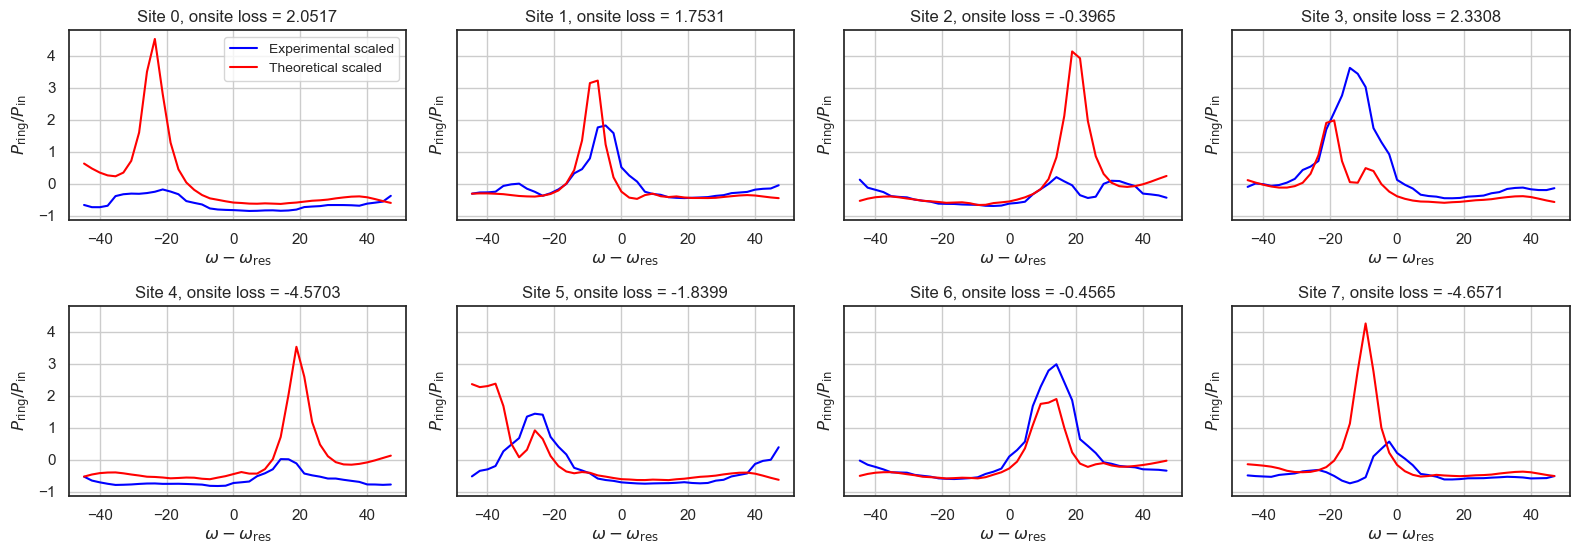

In [31]:
import numpy as np
import matplotlib.pyplot as plt

plotx = frequencies


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True, sharey=True)

k = 7
for i in range(8):
    ax = axes[i // 4, i % 4]  # Row-major order: 2 rows, 4 columns

    ax.plot(frequencies, new_y_train_scaled[i+(8*k), :], label='Experimental scaled', color='blue')
    ax.plot(frequencies, new_X_train_scaled[i+(8*k), :], label='Theoretical scaled', color='red')

    #ax.set_title(f"Site {i}, sample {k+1}")
    ax.set_title(f"Site {i}, onsite loss = {y_combined_pred[k,i]:.4f}")
    ax.set_xlabel(r"$\omega-\omega_{\mathrm{res}}$")
    ax.set_ylabel(r"$P_{\mathrm{ring}}/P_{\mathrm{in}}$")
    #ax.set_ylim(y_min, y_max)
    ax.grid(True)
    
    if i // 4 == 0:  # First row: force show x-tick labels
        ax.tick_params(labelbottom=True)

    if i == 0:
        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
#plt.savefig("spectra_sample_24.png", dpi=300, bbox_inches='tight')
plt.show()


In [32]:
#model1 = create_model_for_sanity_check1(input_shape=new_X_train_scaled.shape[1:])
#model1.compile(optimizer="adam", loss="mse")
##early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#history1 = model1.fit(new_X_train_scaled, new_y_train_scaled, epochs=100, batch_size=16, validation_split=0.2)
##history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2, callbacks=[early_stopping])
new_X_train_scaled_cnn = new_X_train_scaled[..., np.newaxis]
new_X_test_scaled_cnn  = new_X_test_scaled[..., np.newaxis]

# Build CNN model
#model_sc = create_stage2_cnn(input_shape=new_X_train_scaled_cnn.shape[1:])
model_sc = simple_spectrum_cnn()
model_sc.compile(optimizer="adam", loss="mse")


# Train
history_sc = model_sc.fit(new_X_train_scaled_cnn, new_y_train_scaled,epochs=100, batch_size=16, validation_split=0.2)


# Evaluate
loss1 = model_sc.evaluate(new_X_test_scaled_cnn, new_y_test_scaled)
print(f"Test Loss: {loss1:.6f}")

#loss1 = model1.evaluate(new_X_test_scaled, new_y_test_scaled)
#print(f"Test Loss (noise_std={noise_std}):", loss)

# Predictions
new_y_pred_test = model_sc.predict(new_X_test_scaled)
new_y_pred_train = model_sc.predict(new_X_train_scaled)

print(new_y_pred_train.shape)
print(new_y_train.shape)
print(new_y_pred_test.shape)
print(new_y_test.shape)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0654 - val_loss: 0.9681
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9509 - val_loss: 0.9567
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8790 - val_loss: 0.9383
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8665 - val_loss: 0.8803
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7470 - val_loss: 0.8240
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7185 - val_loss: 0.7313
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8049 - val_loss: 0.6768
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6615 - val_loss: 0.6189
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6989 - val_loss: 0.5964
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6334 - val_loss: 0.5788
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6947 - val_loss: 0.6121
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5335 - val_loss: 0.5312
Epoch 70/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5386 - val_loss: 0.5408
Epoch 71/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5910 - val_loss: 0.5237
Epoch 72/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5428 - val_loss: 0.5258
Epoch 73/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6183 - val_loss: 0.5352
Epoch 74/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5404 - val_loss: 0.5623
Epoch 75/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5626 - val_loss: 0.5260
Epoch 76/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5448 - val_loss: 0.5359
Epoch 77/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5583 - val_loss: 0.5211
Epoch 78/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5627 - val_loss: 0.5324
Epoch 79/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5462 - val_loss: 0.5228
Epoch 80/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5015 

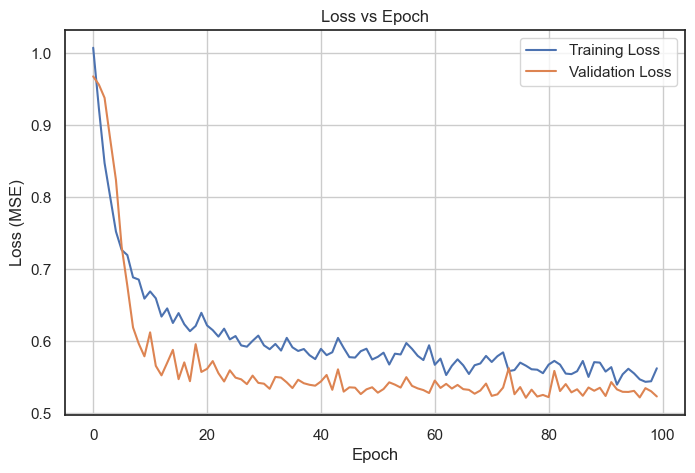

In [33]:
import matplotlib.pyplot as plt

# Extract training and validation loss from history
train_loss = history_sc.history['loss']
val_loss = history_sc.history['val_loss']

# Plot
plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
pred_y_train = scalerny.inverse_transform(new_y_pred_train)
pred_y_test = scalerny.inverse_transform(new_y_pred_test)

#pred_y_train = new_y_pred_train
#pred_y_test = new_y_pred_test

true_y_train = new_y_train
true_y_test = new_y_test


In [36]:
print(pred_y_test.shape)
print(y_comb_pred_test.flatten().shape)

(306, 40)
(306,)


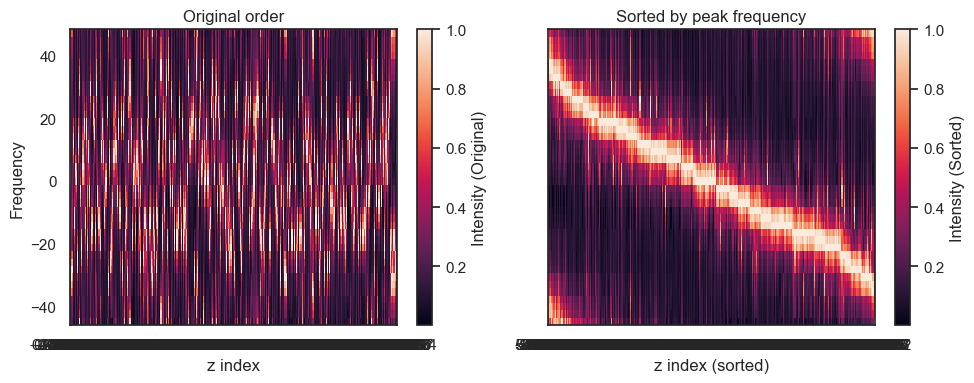

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# --- Example data ---
z = np.array(y_comb_pred_test.flatten())
frequencies1 = np.array(frequencies)
#S = np.array(true_y_test)
S = true_y_test / np.max(true_y_test, axis=1, keepdims=True)


# --- Sorting by where each row peaks ---
def sort_by_peak_frequency(z, S):
    peak_idx = np.argmax(S, axis=1)
    peak_amp = S[np.arange(S.shape[0]), peak_idx]
    order = np.lexsort((-peak_amp, peak_idx))
    return z[order], S[order, :], order

z_new, S_new, order = sort_by_peak_frequency(z, S)

# numeric z positions for plotting
z_numeric     = np.arange(len(z))
z_numeric_new = np.arange(len(z_new))

# --- Plot side-by-side: Original vs Sorted (z on x, f on y) ---
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# Left: Original
pc1 = axs[0].pcolormesh(z_numeric, frequencies1, S.T, shading='auto')
axs[0].set_title("Original order")
axs[0].set_xlabel("z index")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks(z_numeric + 0.5)
axs[0].set_xticklabels(z)
fig.colorbar(pc1, ax=axs[0], label="Intensity (Original)")

# Right: Sorted
pc2 = axs[1].pcolormesh(z_numeric_new, frequencies1, S_new.T, shading='auto')
axs[1].set_title("Sorted by peak frequency")
axs[1].set_xlabel("z index (sorted)")
axs[1].set_xticks(z_numeric_new + 0.5)
axs[1].set_xticklabels(z_new)
fig.colorbar(pc2, ax=axs[1], label="Intensity (Sorted)")

plt.tight_layout()
plt.show()

In [42]:
#Sk = np.array(pred_y_test)
Sk = pred_y_test/ np.max(pred_y_test, axis=1, keepdims=True)

Sk_new = Sk[order, :]

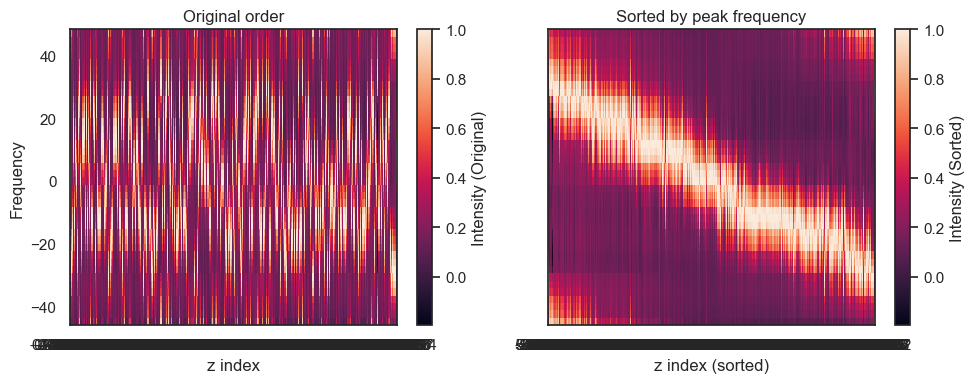

In [43]:
# --- Plot side-by-side: Original vs Sorted (z on x, f on y) ---
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# Left: Original
pc1 = axs[0].pcolormesh(z_numeric, frequencies, Sk.T, shading='auto')
axs[0].set_title("Original order")
axs[0].set_xlabel("z index")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks(z_numeric + 0.5)
axs[0].set_xticklabels(z)
fig.colorbar(pc1, ax=axs[0], label="Intensity (Original)")

# Right: Sorted
pc2 = axs[1].pcolormesh(z_numeric_new, frequencies, Sk_new.T, shading='auto')
axs[1].set_title("Sorted by peak frequency")
axs[1].set_xlabel("z index (sorted)")
axs[1].set_xticks(z_numeric_new + 0.5)
axs[1].set_xticklabels(z_new)
fig.colorbar(pc2, ax=axs[1], label="Intensity (Sorted)")

plt.tight_layout()
plt.show()

In [44]:
import numpy as np

# Suppose we already have:
# z_sorted : shape (N,) = (320,)
# frequencies : shape (F,) = (40,)
# S_sorted : shape (N, F)
# Sk_sorted : shape (N, F)

# --- Flatten to long table (z, freq, S, Sk) ---
N, F = S_new.shape

# Repeat z along each frequency
z_col0 = np.repeat(z_new + 0.5, F) 
z_col = np.repeat(z_numeric_new + 0.5, F)              # (N*F,)
# Tile frequencies for each z
f_col = np.tile(frequencies, N)             # (N*F,)

# Flatten spectra values
S_col  = S_new.flatten(order="C")        # (N*F,)
Sk_col = Sk_new.flatten(order="C")       # (N*F,)

# Stack into one 2D array
data = np.column_stack([z_col0,z_col, f_col, S_col, Sk_col])

# --- Save to file ---
header = "z_sorted\tz_sorted_numeric\tfrequency\tS_sorted\tSk_sorted"
np.savetxt(
    "out_by_m/spectra_sorted_new.dat",
    data,
    fmt="%.10g",
    delimiter="\t",
    header=header,
    comments=""
)

print("✅ Saved spectra_sorted.dat with shape", data.shape)

✅ Saved spectra_sorted.dat with shape (12240, 5)


"Stop here below is hilbert space fitting"


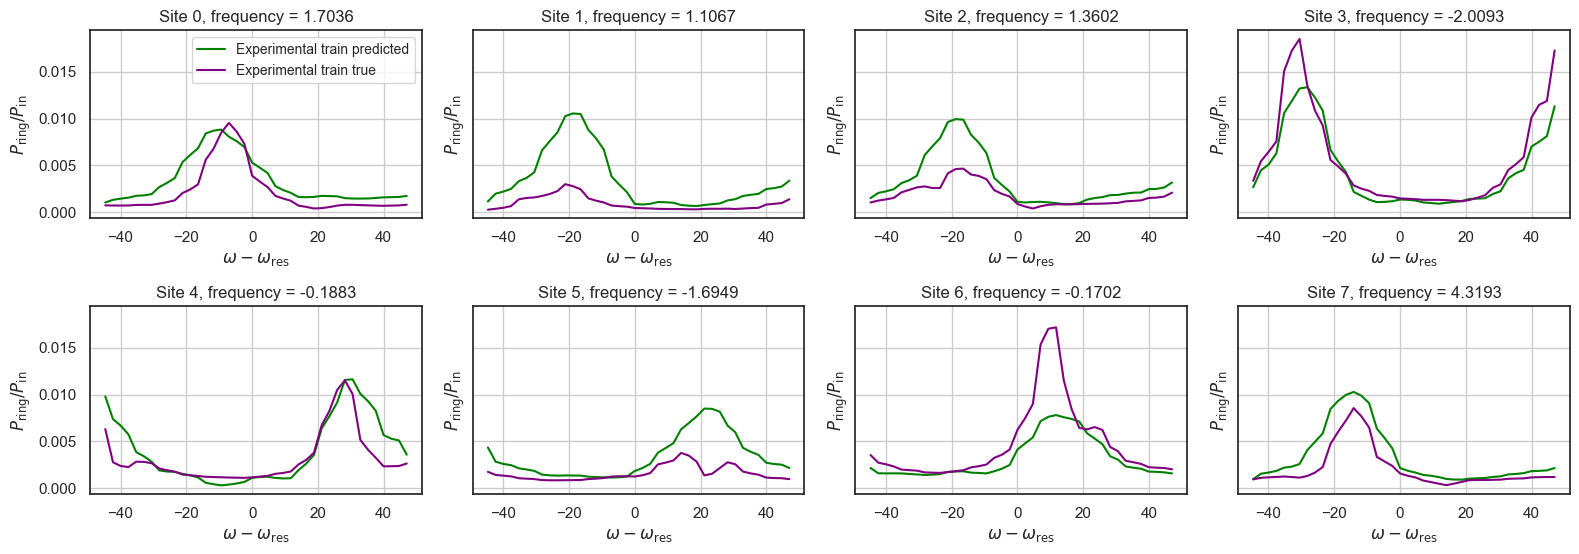

In [35]:
import numpy as np
import matplotlib.pyplot as plt

plotx = frequencies


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True, sharey=True)

k = 18
for i in range(8):
    ax = axes[i // 4, i % 4]  # Row-major order: 2 rows, 4 columns

    ax.plot(frequencies, pred_y_train[i+(8*k), :], label='Experimental train predicted', color='green')
    ax.plot(frequencies, true_y_train[i+(8*k), :], label='Experimental train true', color='purple')

    #ax.set_title(f"Site {i}, sample {k+1}")
    ax.set_title(f"Site {i}, frequency = {y_comb_pred_train[k+i]:.4f}")
    ax.set_xlabel(r"$\omega-\omega_{\mathrm{res}}$")
    ax.set_ylabel(r"$P_{\mathrm{ring}}/P_{\mathrm{in}}$")
    #ax.set_ylim(y_min, y_max)
    ax.grid(True)
    
    if i // 4 == 0:  # First row: force show x-tick labels
        ax.tick_params(labelbottom=True)

    if i == 0:
        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
#plt.savefig("spectra_sample_24.png", dpi=300, bbox_inches='tight')
plt.show()

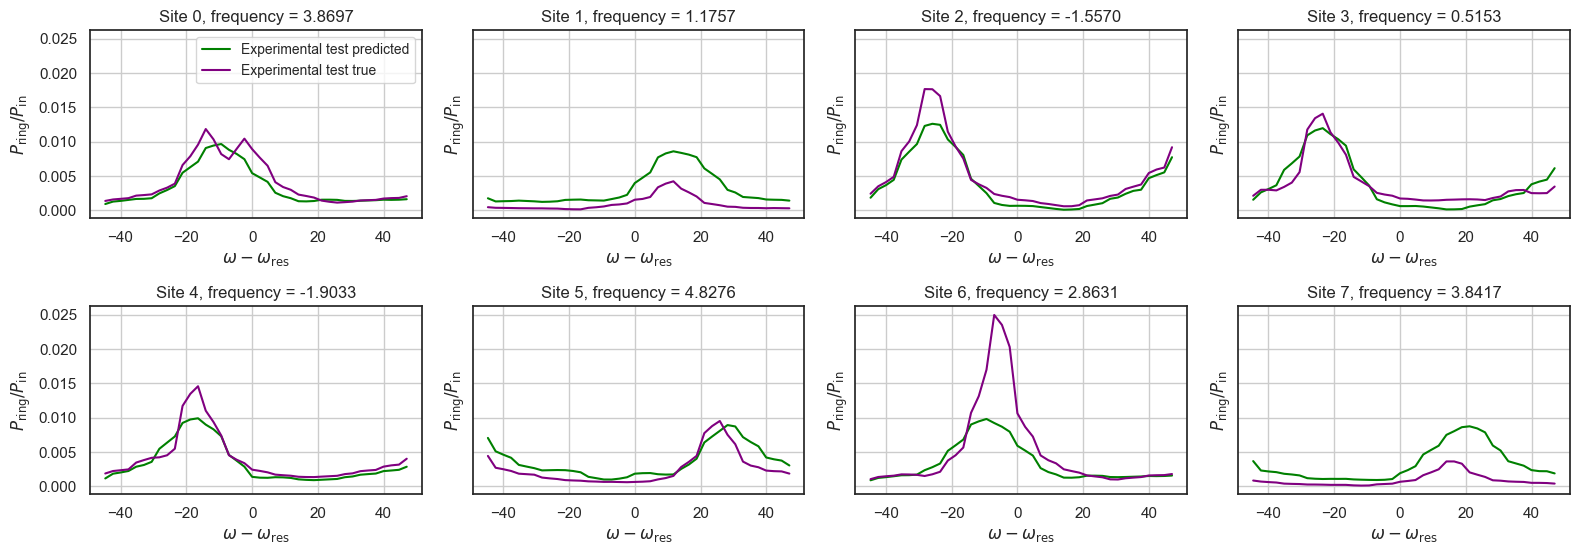

In [36]:
import numpy as np
import matplotlib.pyplot as plt

plotx = frequencies


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True, sharey=True)

k = 8
for i in range(8):
    ax = axes[i // 4, i % 4]  # Row-major order: 2 rows, 4 columns

    ax.plot(frequencies, pred_y_test[i+(8*k), :], label='Experimental test predicted', color='green')
    ax.plot(frequencies, true_y_test[i+(8*k), :], label='Experimental test true', color='purple')

    #ax.set_title(f"Site {i}, sample {k+1}")
    ax.set_title(f"Site {i}, frequency = {y_comb_pred_test[k+i]:.4f}")
    ax.set_xlabel(r"$\omega-\omega_{\mathrm{res}}$")
    ax.set_ylabel(r"$P_{\mathrm{ring}}/P_{\mathrm{in}}$")
    #ax.set_ylim(y_min, y_max)
    ax.grid(True)
    
    if i // 4 == 0:  # First row: force show x-tick labels
        ax.tick_params(labelbottom=True)

    if i == 0:
        ax.legend(fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
#plt.savefig("spectra_sample_24.png", dpi=300, bbox_inches='tight')
plt.show()

In [37]:
import os
import numpy as np

def save_by_m(frequencies, pred_y_test, true_y_test, datay1_test,
              out_dir="out_by_m", delimiter="\t"):
    """
    Save 8 files, one for each m in [0..7], aggregating over all k.
    Each file has columns:
        k, m, freq, pred, true, loss

    Shapes assumed (consistent with your original indexing):
      - frequencies: (F,)
      - pred_y_test / true_y_test: stacked as idx = m + 8*k, each row length F
      - datay1_test: shape (K, 8) giving the 'loss' per (k, m)
    """
    os.makedirs(out_dir, exist_ok=True)
    F = frequencies.shape[0]
    K = datay1_test.shape[0]

    for m in range(8):
        rows = []
        for k in range(K):
            idx = m + 8 * k
            loss = float(datay1_test[k, m])
            block = np.column_stack([
                np.full(F, k, dtype=int),     # k
                np.full(F, m, dtype=int),     # m (constant within this file)
                frequencies,                  # freq
                pred_y_test[idx],             # pred
                true_y_test[idx],             # true
                np.full(F, loss, dtype=float) # loss (per k,m)
            ])
            rows.append(block)

        M = np.vstack(rows)
        out_path = os.path.join(out_dir, f"m{m}_allk_freq_pred_true_loss.dat")
        header = "k\tm\tfreq\tpred\ttrue\tloss"
        np.savetxt(out_path, M,
                   fmt=["%d","%d","%.10g","%.10g","%.10g","%.10g"],
                   delimiter=delimiter, header=header, comments="")
        print(f"Saved {out_path} | shape={M.shape}")


In [38]:
#save_by_m(
#    frequencies=frequencies,
#    pred_y_test=pred_y_test[0:304,:],
#    true_y_test=true_y_test[0:304,:],
#    datay1_test=y_comb_pred_test[0:304].reshape(38,8),
#    out_dir="out_by_m"   # folder where the 8 files will be saved
#)

In [39]:
import numpy as np

# ---------- Hilbert utils ----------
def _rot(n, x, y, rx, ry):
    if ry == 0:
        if rx == 1:
            x = n - 1 - x
            y = n - 1 - y
        x, y = y, x
    return x, y

def _xy2d(n, x, y):
    d = 0
    s = n // 2
    while s > 0:
        rx = 1 if (x & s) else 0
        ry = 1 if (y & s) else 0
        d += s * s * ((3 * rx) ^ ry)
        x, y = _rot(s, x, y, rx, ry)
        s //= 2
    return d

# -----------------------------------

def hilbert_xyz_any_sign(x, y, k=16):
    """
    Forward + backward mapping between real (x,y) and Hilbert z.
    Works for negative x,y.
    Returns (x_scaled, y_scaled, z)
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    assert x.shape == y.shape

    # Normalize
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    xr = (x - x_min) / (x_max - x_min + 1e-15)
    yr = (y - y_min) / (y_max - y_min + 1e-15)

    N = 1 << k
    scale = N - 1
    xi = np.clip((xr * scale).round().astype(np.uint32), 0, scale)
    yi = np.clip((yr * scale).round().astype(np.uint32), 0, scale)

    # Hilbert index
    z = np.fromiter((_xy2d(N, int(a), int(b)) for a, b in zip(xi, yi)),
                    dtype=np.uint64, count=len(xi))
    z_scaled = (z - z.min()) / (z.max() - z.min())
    return x, y, z_scaled

In [40]:
x = np.arange(8)
Nx = 8
R = 38
y = y_comb_pred_test[0:304]
y_grid = y.reshape(Nx, R)        # (Nx, R)
x_pairs = np.repeat(x, R)        # (Nx*R,)
y_pairs = y_grid.reshape(-1)     # (Nx*R,)
x1, y1, z = hilbert_xyz_any_sign(x_pairs, y_pairs, k=10)

In [44]:
#assert len(np.unique(y_pairs, axis=0)) == len(np.unique(z))
print(len(np.unique(z)),len(z))

303 304


In [45]:
z_unique = z.astype(np.float64) + 1e-9 * np.arange(len(z))


In [46]:
assert len(np.unique(y_pairs, axis=0)) == len(np.unique(z_unique))
print(len(np.unique(z_unique)),len(z_unique))

304 304


In [47]:
import numpy as np

def save_all_km_single(frequencies, pred_y_test, true_y_test,
                       datay1_test=None,  # optional: loss per (k,m)
                       z=None,            # optional: Hilbert-curve value(s)
                       out_path="all_k_m_freq_pred_true_loss_z.dat",
                       delimiter="\t"):
    """
    Save ONE file stacking all k and m (0..7) over all frequencies.
    Columns: k, m, freq, pred, true, loss, z

    Assumptions:
      - frequencies: shape (F,)
      - pred_y_test / true_y_test are stacked with idx = m + 8*k, each row length F
      - If datay1_test is provided: shape (K, 8) giving 'loss' per (k,m)
      - z can be:
          * None -> column filled with NaN
          * shape (K, 8) -> scalar per (k,m), broadcast across F
          * shape (K, 8, F) -> value per (k,m,f)
    """
    frequencies = np.asarray(frequencies)
    F = frequencies.shape[0]

    pred_y_test = np.asarray(pred_y_test)
    true_y_test = np.asarray(true_y_test)

    # infer K from stacked rows length
    if pred_y_test.ndim != 2 or pred_y_test.shape[1] != F:
        raise ValueError("pred_y_test must be 2D with shape (8*K, F)")
    if true_y_test.shape != pred_y_test.shape:
        raise ValueError("true_y_test shape must match pred_y_test")

    rows_stacked = pred_y_test.shape[0]
    if rows_stacked % 8 != 0:
        raise ValueError("pred_y_test rows not divisible by 8; cannot infer K")
    K = rows_stacked // 8

    # prepare loss
    if datay1_test is None:
        datay1_test = np.full((K, 8), np.nan, dtype=float)
    else:
        datay1_test = np.asarray(datay1_test)
        if datay1_test.shape != (K, 8):
            raise ValueError(f"datay1_test must have shape (K, 8) = ({K}, 8)")

    # prepare z
    z_mode = "none"
    if z is None:
        # fill later with NaN
        pass
    else:
        z = np.asarray(z)
        if z.shape == (K, 8):
            z_mode = "km"
        elif z.shape == (K, 8, F):
            z_mode = "kmf"
        else:
            raise ValueError(f"z must have shape (K,8) or (K,8,F); got {z.shape}")

    blocks = []
    for k in range(K):
        for m in range(8):
            idx = m + 8 * k
            loss_km = float(datay1_test[k, m])

            # choose z column for this (k,m)
            if z_mode == "none":
                z_col = np.full(F, np.nan, dtype=float)
            elif z_mode == "km":
                z_col = np.full(F, float(z[k, m]), dtype=float)
            else:  # "kmf"
                z_col = z[k, m].astype(float)

            block = np.column_stack([
                np.full(F, k, dtype=int),          # k
                np.full(F, m, dtype=int),          # m
                frequencies,                       # freq
                pred_y_test[idx],                  # pred
                true_y_test[idx],                  # true
                np.full(F, loss_km, dtype=float),  # loss
                z_col                               # z
            ])
            blocks.append(block)

    M = np.vstack(blocks)

    header = "k\tm\tfreq\tpred\ttrue\tloss\tz"
    np.savetxt(out_path, M,
               fmt=["%d","%d","%.10g","%.10g","%.10g","%.10g","%.10g"],
               delimiter=delimiter, header=header, comments="")
    print(f"Saved {out_path} | shape={M.shape} | K={K}, F={F}")


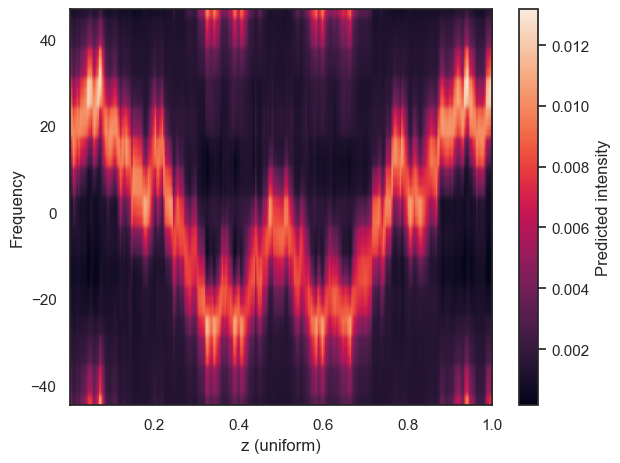

In [48]:
from scipy.interpolate import interp1d
pred_y_test=pred_y_test[0:304,:]
true_y_test=true_y_test[0:304,:]
datay1_test=y_comb_pred_test[0:304].reshape(38,8)

N = pred_y_test.shape[0]
z = z_unique.copy()
order = np.argsort(z)
z_sorted = z[order]
Z_p = pred_y_test[order, :]                      # (N, F)

# Build a uniform z axis
z_uniform = np.linspace(z_sorted.min(), z_sorted.max(), N)

# Interpolate each frequency column onto uniform z
Z_uniform_p = np.empty_like(Z_p)
for j in range(Z_p.shape[1]):
    f = interp1d(z_sorted, Z_p[:, j], kind='linear', fill_value='extrapolate', assume_sorted=True)
    Z_uniform_p[:, j] = f(z_uniform)

plt.figure()
plt.imshow(Z_uniform_p.T, aspect='auto',
           extent=[z_uniform.min(), z_uniform.max(), frequencies.min(), frequencies.max()],
           origin='lower')
plt.xlabel('z (uniform)')
plt.ylabel('Frequency')
plt.colorbar(label='Predicted intensity')
plt.tight_layout()
plt.show()


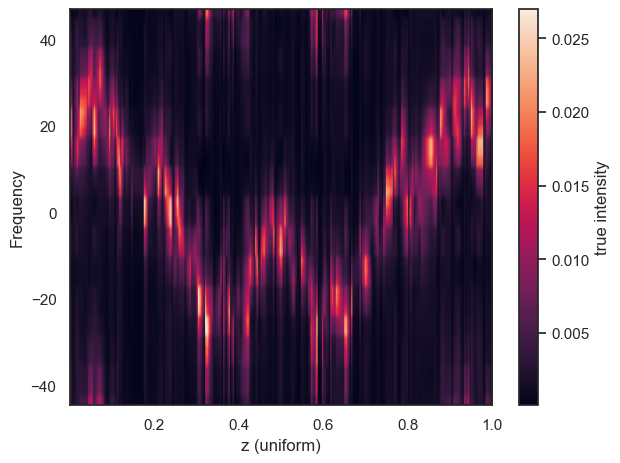

In [49]:
from scipy.interpolate import interp1d

Z_t = true_y_test[order, :]                      # (N, F)


# Interpolate each frequency column onto uniform z
Z_uniform_t = np.empty_like(Z_t)
for j in range(Z_t.shape[1]):
    f = interp1d(z_sorted, Z_t[:, j], kind='linear', fill_value='extrapolate', assume_sorted=True)
    Z_uniform_t[:, j] = f(z_uniform)

plt.figure()
plt.imshow(Z_uniform_t.T, aspect='auto',
           extent=[z_uniform.min(), z_uniform.max(), frequencies.min(), frequencies.max()],
           origin='lower')
plt.xlabel('z (uniform)')
plt.ylabel('Frequency')
plt.colorbar(label='true intensity')
plt.tight_layout()
plt.show()

In [50]:
K = 38                             # number of k’s
F = frequencies.shape[0]            # number of frequency samples

# z_flat has length 8*K (320). Match idx = m + 8*k  → row=k, col=m
z_km = z_uniform.reshape(K, 8)         # shape (K, 8): z[k, m]

# (Optional) quick sanity check: z_km[k, m] == z_flat[m + 8*k]
# assert np.allclose(z_km.ravel(order="C"), z_flat)

#save_all_km_single(
#    frequencies=frequencies,        # shape (F,)
#    pred_y_test=Z_uniform_p,        # shape (8*K, F) stacked with idx = m + 8*k
#    true_y_test=Z_uniform_t,        # shape (8*K, F) same stacking
#    datay1_test=datay1_test,        # shape (K, 8) losses per (k, m). Or pass None.
#    z=z_km,                         # shape (K, 8) → broadcast across frequencies
#    out_path="out_by_m/all_km_freq_pred_true_loss_z1.dat"
#)


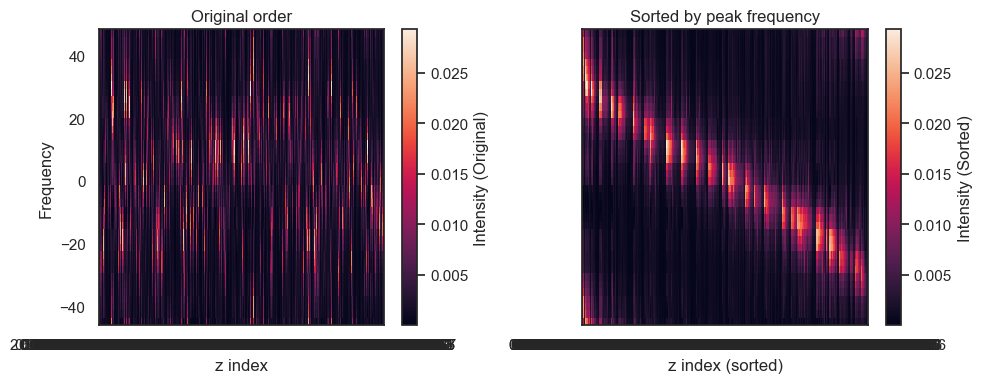

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# --- Example data ---
z = np.array(z_uniform)
frequencies1 = np.array(frequencies)
S = np.array(true_y_test)

# --- Sorting by where each row peaks ---
def sort_by_peak_frequency(z, S):
    peak_idx = np.argmax(S, axis=1)
    peak_amp = S[np.arange(S.shape[0]), peak_idx]
    order = np.lexsort((-peak_amp, peak_idx))
    return z[order], S[order, :], order

z_new, S_new, order = sort_by_peak_frequency(z, S)

# numeric z positions for plotting
z_numeric     = np.arange(len(z))
z_numeric_new = np.arange(len(z_new))

# --- Plot side-by-side: Original vs Sorted (z on x, f on y) ---
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# Left: Original
pc1 = axs[0].pcolormesh(z_numeric, frequencies1, S.T, shading='auto')
axs[0].set_title("Original order")
axs[0].set_xlabel("z index")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks(z_numeric + 0.5)
axs[0].set_xticklabels(z)
fig.colorbar(pc1, ax=axs[0], label="Intensity (Original)")

# Right: Sorted
pc2 = axs[1].pcolormesh(z_numeric_new, frequencies1, S_new.T, shading='auto')
axs[1].set_title("Sorted by peak frequency")
axs[1].set_xlabel("z index (sorted)")
axs[1].set_xticks(z_numeric_new + 0.5)
axs[1].set_xticklabels(z_new)
fig.colorbar(pc2, ax=axs[1], label="Intensity (Sorted)")

plt.tight_layout()
plt.show()


In [52]:
Sk = np.array(pred_y_test)
Sk_new = Sk[order, :]

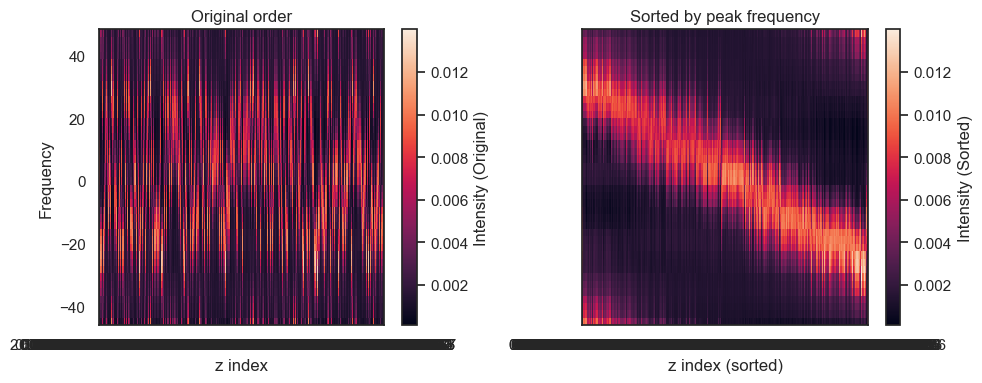

In [53]:
# --- Plot side-by-side: Original vs Sorted (z on x, f on y) ---
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# Left: Original
pc1 = axs[0].pcolormesh(z_numeric, frequencies, Sk.T, shading='auto')
axs[0].set_title("Original order")
axs[0].set_xlabel("z index")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks(z_numeric + 0.5)
axs[0].set_xticklabels(z)
fig.colorbar(pc1, ax=axs[0], label="Intensity (Original)")

# Right: Sorted
pc2 = axs[1].pcolormesh(z_numeric_new, frequencies, Sk_new.T, shading='auto')
axs[1].set_title("Sorted by peak frequency")
axs[1].set_xlabel("z index (sorted)")
axs[1].set_xticks(z_numeric_new + 0.5)
axs[1].set_xticklabels(z_new)
fig.colorbar(pc2, ax=axs[1], label="Intensity (Sorted)")

plt.tight_layout()
plt.show()

In [54]:
import numpy as np

# Suppose we already have:
# z_sorted : shape (N,) = (320,)
# frequencies : shape (F,) = (40,)
# S_sorted : shape (N, F)
# Sk_sorted : shape (N, F)

# --- Flatten to long table (z, freq, S, Sk) ---
N, F = S_new.shape

# Repeat z along each frequency
z_col = np.repeat(z_numeric_new + 0.5, F)              # (N*F,)
# Tile frequencies for each z
f_col = np.tile(frequencies, N)             # (N*F,)

# Flatten spectra values
S_col  = S_new.flatten(order="C")        # (N*F,)
Sk_col = Sk_new.flatten(order="C")       # (N*F,)

# Stack into one 2D array
data = np.column_stack([z_col, f_col, S_col, Sk_col])

# --- Save to file ---
header = "z_sorted\tfrequency\tS_sorted\tSk_sorted"
np.savetxt(
    "out_by_m/spectra_sorted.dat",
    data,
    fmt="%.10g",
    delimiter="\t",
    header=header,
    comments=""
)

print("✅ Saved spectra_sorted.dat with shape", data.shape)


✅ Saved spectra_sorted.dat with shape (12160, 4)
